# This notebook is to compute linear receptive field

In [1]:
JSON_FILE_IDX = 1   # 1, 3, 5, 6, 7

In [2]:
#SAVE_TO_HDF5 = 0
SAVE_SUMMARY = 0

## 1. setup

In [3]:
import os
import sys
sys.path.append('../')
home_dir = '/Users'
proj_dir = home_dir + '/dlee/imaging/'
ext_dir = proj_dir + 'data-extract/'

In [4]:
import numpy as np
import scipy.io
import scipy.signal
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nl
import utils
import stats

## 2. Load .json file

In [5]:
json_file_list = ['0.json', '1.json', '2.json',              # 23-06-16    
                  '3.json', '4.json',                        # 23-06-20
                  '5.json', '6.json', '7.json', '8.json',    # 23-06-26
                  '9.json']                                  # 23-06-26 sort2
n_sess = len(json_file_list)

In [6]:
jsl = {}
for j in range(n_sess):
    with open(proj_dir + 'json/' + json_file_list[j], 'r') as js:
        jsl[j] = json.load(js)
p = jsl[JSON_FILE_IDX]
print(jsl[0].keys())
print('total number of json files:', len(jsl))

dict_keys(['exp_id', 'exp_date', 'exp_session', 'roi_trace', 'roi_snap', 'p', 'pd_trace', 'pd_threshold', 'cc', 'loc', 'wn', 'nm', 'zoom', 'laser_percent', 'GCL', 'INL', 'flipTime', 'test_repeat', 'test_seed', 'test_fr', 'test_totalFrame', 'test_totalFrame30', 'test_totalFrame60', 'test_box_size', 'train_repeat', 'train_seed', 'train_fr', 'train_totalFrame', 'train_totalFrame30', 'train_totalFrame60', 'train_box_size', 'roi_threshold', 'resp_idx', 'n_before', 'n_after', 'space_1_idx', 'space_2_idx', 'space_sigma', 'time_sigma'])
total number of json files: 10


## 3. Load .h5 file

In [7]:
h5_file_list = [str(jsl[j]['exp_id']) + '_' + jsl[j]['roi_trace'][:-14] + '.h5' for j in range(n_sess)]
h5_file_list

['0_23-06-16-loc1-wn.h5',
 '1_23-06-16-loc2-nm.h5',
 '2_23-06-16-loc3-wn.h5',
 '3_23-06-20-loc3-nm.h5',
 '4_23-06-20-loc4-wn.h5',
 '5_23-06-26-loc1-nm.h5',
 '6_23-06-26-loc2-nm.h5',
 '7_23-06-26-loc3-nm.h5',
 '8_23-06-26-loc3-wn.h5',
 '9_23-06-26-loc3-wn.h5']

In [8]:
ex = {}
with h5py.File(ext_dir + h5_file_list[JSON_FILE_IDX]) as f:
    ex['stim_tr'] = np.double(f['train/stim'])
    ex['resp_tr'] = np.double(f['train/resp'])
    ex['tbins_tr'] = np.double(f['train/tbins'])
    ex['jitter_tr'] = np.double(f['train/jitter'])
    ex['stim_te'] = np.double(f['test/stim'])
    ex['resp_te'] = np.double(f['test/resp'])
    ex['tbins_te'] = np.double(f['test/tbins'])
    ex['jitter_te'] = np.double(f['test/jitter'])
    ex['cc_te'] = np.double(f['test/cc'])

## 4. Compute motion field

In [9]:
n_roi = ex['resp_tr'].shape[0]
n_roi

283

In [10]:
n_before = 45  #120
n_after = 20   #60

In [11]:
tbins_rc_dj = np.arange(-(ex['tbins_tr'][1] * n_before), 
                        ex['tbins_tr'][1] * n_after, 
                        ex['tbins_tr'][1])[:n_before + n_after]
tbins_rc_dj.shape

(65,)

In [12]:
rc_dj = np.stack([ft.revcorr(np.stack([stats.normalize(
    utils.butter_lf(
        np.gradient(
            ex['jitter_tr']
            , axis=1)
        [:, p['resp_idx'][0] + n_after:p['resp_idx'][1] + n_after].swapaxes(0, 1)[:, xy]
        , Wn_l=12.0, fs=30.0))
                                       for xy in [0, 1]]).swapaxes(0, 1), 
                             stats.normalize(utils.butter_lf(ex['resp_tr'][r, p['resp_idx'][0]:p['resp_idx'][1]], Wn_l=6.0, fs=30.0)), n_before + n_after)[0] 
                  for r in range(n_roi)])

rc_dj.shape

(283, 65, 2)

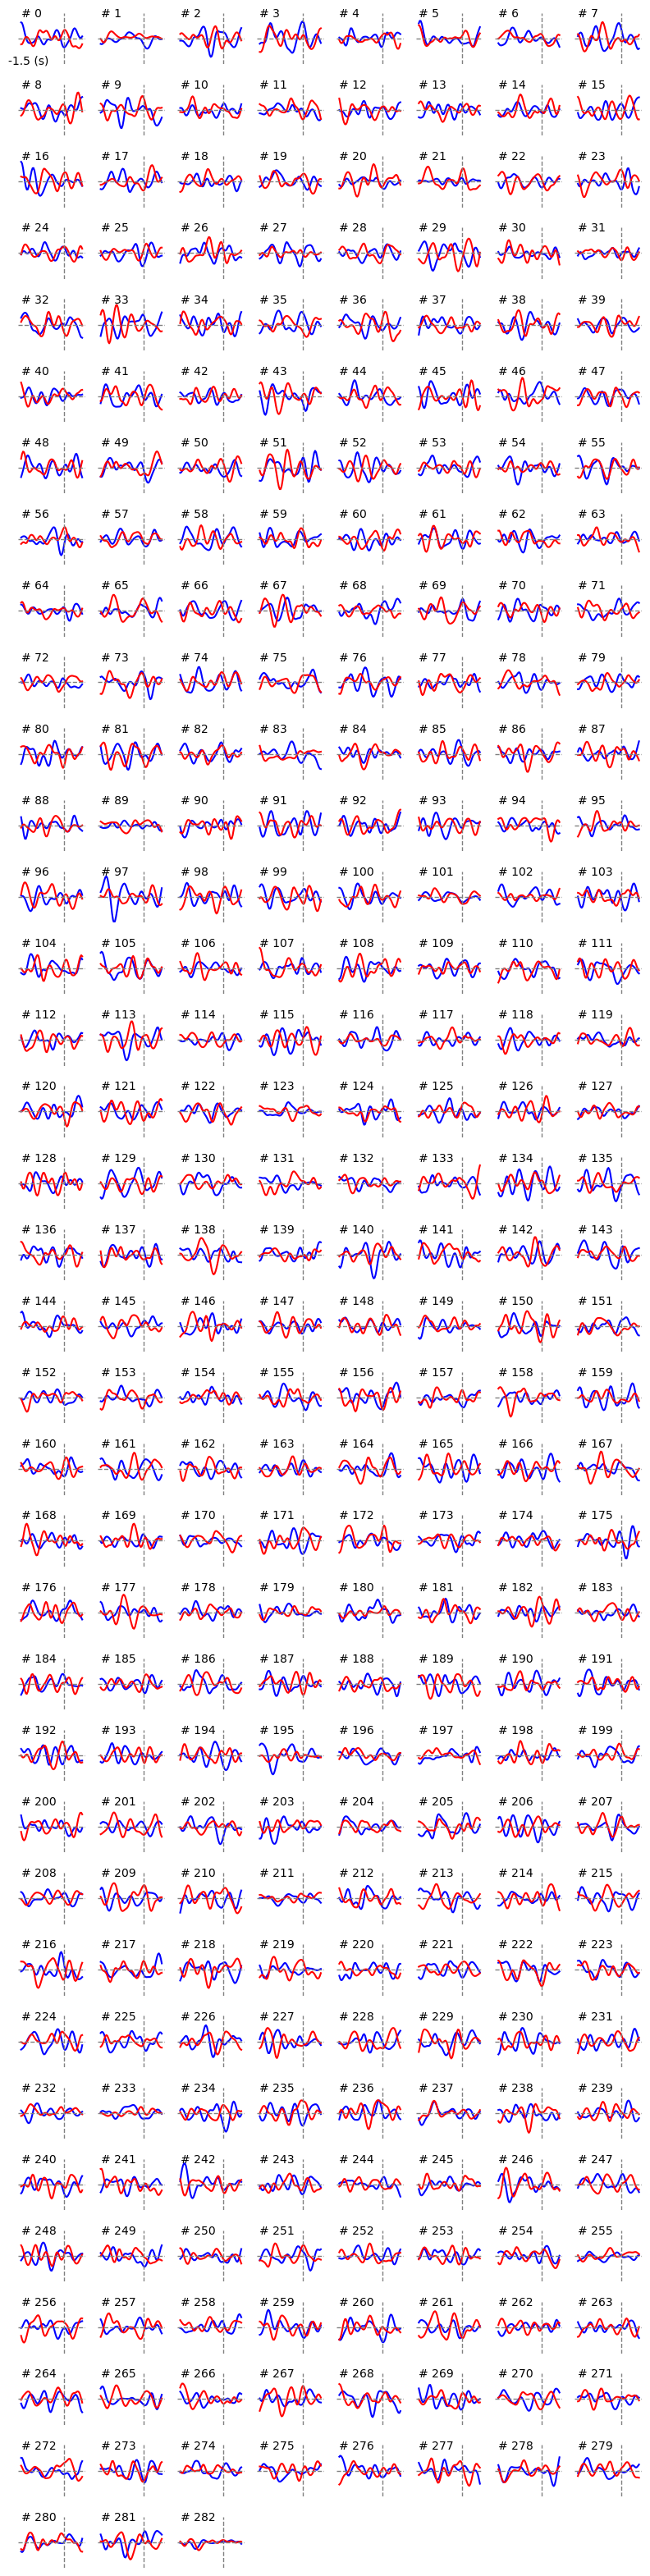

In [13]:
fig = plt.figure(figsize=(8, (n_roi//8)*0.9))
for i in range(n_roi):
    ax = plt.subplot((n_roi//8) + 1, 8, i + 1)
    ax.plot(tbins_rc_dj[:], stats.smooth(rc_dj[i, :, 0], 0.1), linewidth=1.5, color='blue')
    ax.plot(tbins_rc_dj[:], stats.smooth(rc_dj[i, :, 1], 0.1), linewidth=1.5, color='red')
    ax.text(tbins_rc_dj[0], 0.85 * np.max(abs(rc_dj)), '# ' + str(i))
    if i == 0:
        ax.text(tbins_rc_dj[0] * 1.3, -np.max(abs(rc_dj)), str(np.round(tbins_rc_dj[0] * 100)/100) + ' (s)')
    ax.axhline(y=0, color='gray', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='gray', linewidth=1, linestyle='--')
    ax.set_ylim([-np.max(abs(rc_dj)), np.max(abs(rc_dj))])
    ax.axis('off')
plt.tight_layout()

## 5. Compute flip field

In [14]:
flip_tr = np.double(1000 * ([1] + [0] * 149))[:ex['resp_tr'].shape[1]]
flip_tr.shape

(53940,)

In [15]:
tbins_rc_f = tbins_rc_dj
tbins_rc_f.shape

(65,)

In [16]:
rc_f = np.stack([ft.revcorr(stats.normalize(flip_tr[p['resp_idx'][0] + n_after:p['resp_idx'][1] + n_after]), 
                            stats.normalize(utils.butter_lf(ex['resp_tr'][r, p['resp_idx'][0]:p['resp_idx'][1]], Wn_l=6.0, fs=30.0)), 
                            n_before + n_after)[0] for r in range(n_roi)])

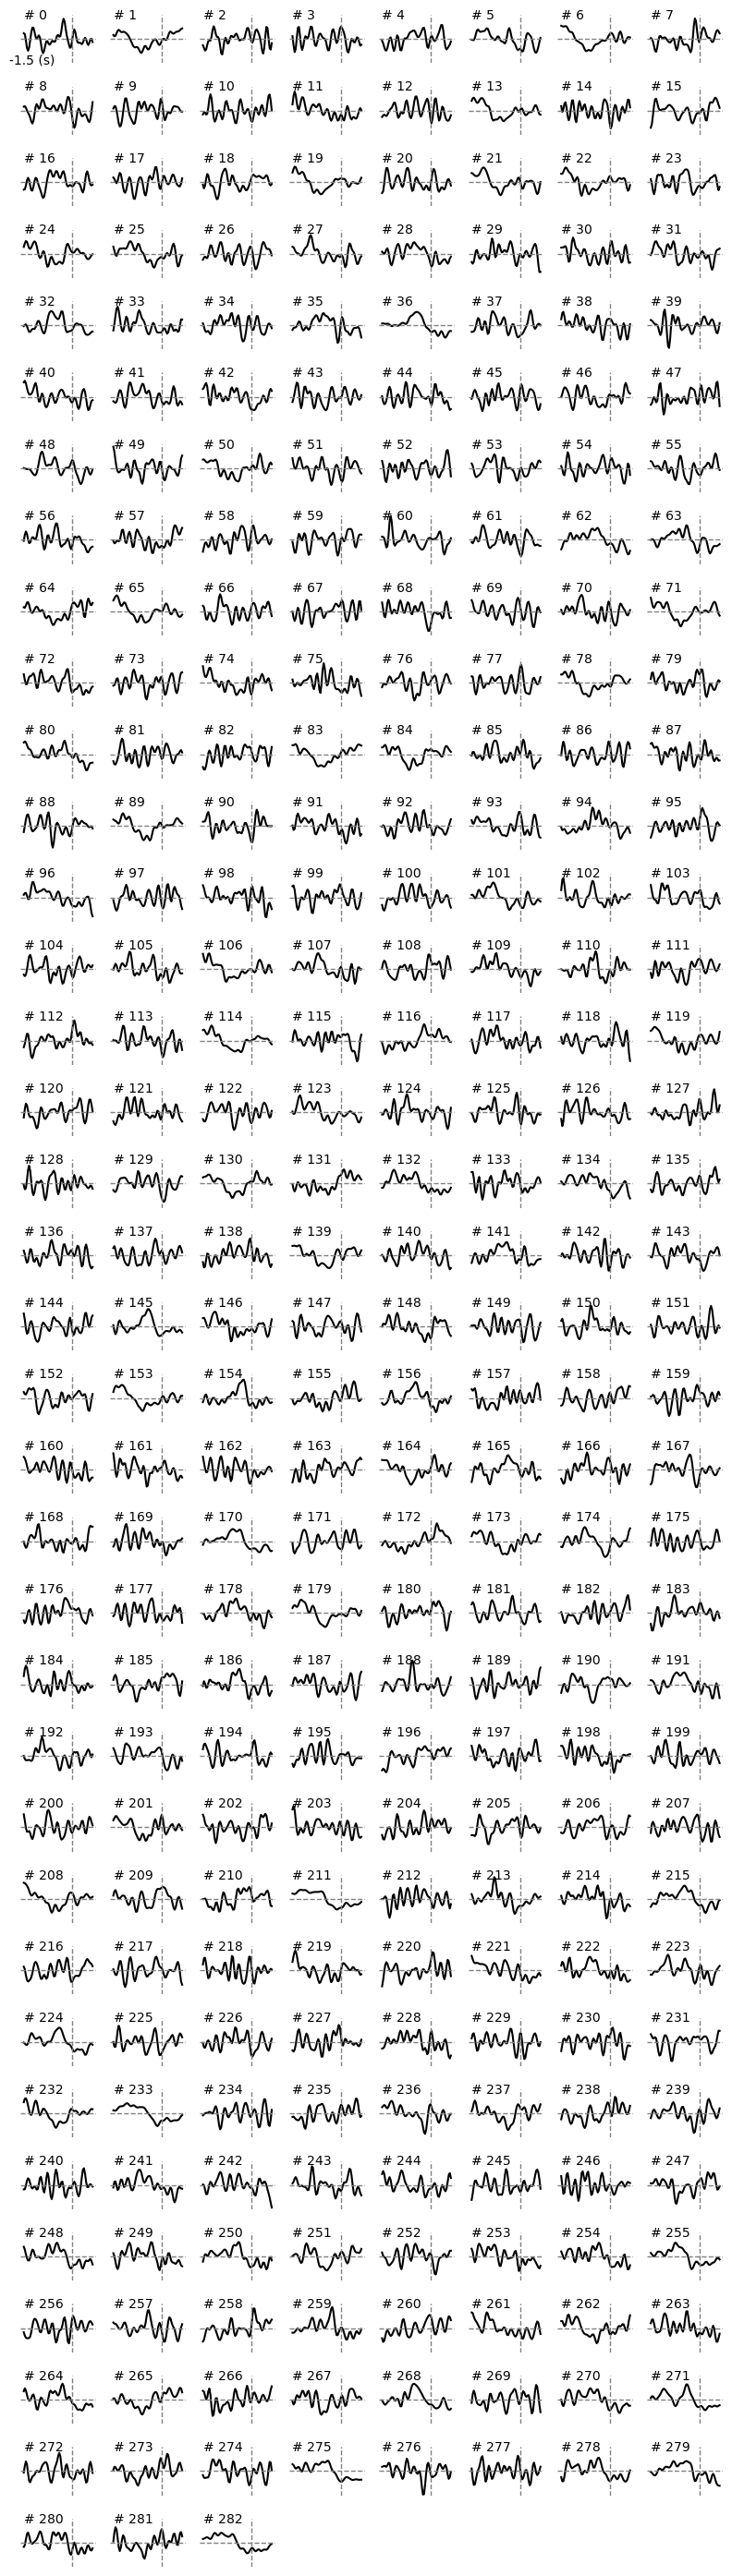

In [17]:
fig = plt.figure(figsize=(8, (n_roi//8)*0.8))
for i in range(n_roi):
    ax = plt.subplot((n_roi//8) + 1, 8, i + 1)
    ax.plot(tbins_rc_f[:], stats.smooth(stats.normalize(rc_f[i, :]), 0.1), linewidth=1.5, color='black')
    ax.text(tbins_rc_f[0], 0.85 * 3.5, '# ' + str(i))
    if i == 0:
        ax.text(tbins_rc_f[0] * 1.3, -3.5, str(np.round(tbins_rc_f[0] * 100)/100) + ' (s)')
    ax.axhline(y=0, color='gray', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='gray', linewidth=1, linestyle='--')
    ax.set_ylim([-3.5, 3.5])
    ax.axis('off')
plt.tight_layout()

## 6. Save as h5 & pdf file

In [18]:
analysis_jitter_dir = proj_dir + 'analysis-jitter/'
analysis_jitter_file = str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_jitter.pdf'

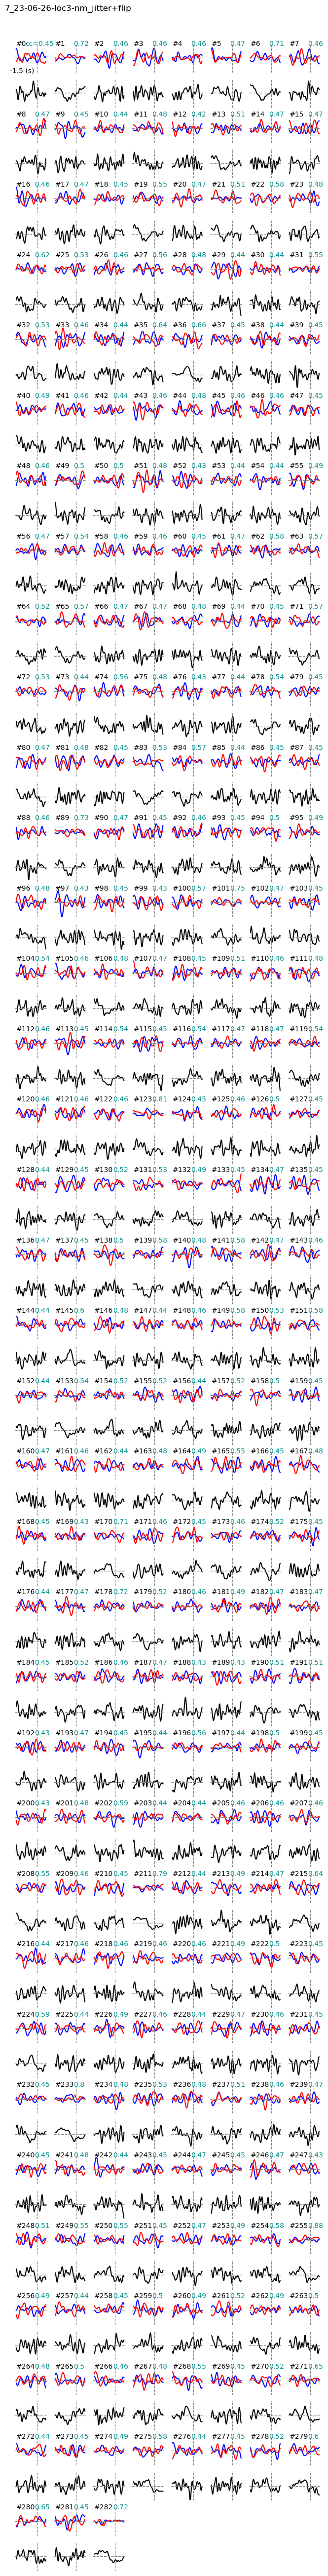

In [19]:
fig = plt.figure(figsize=(8, (n_roi//8)*1.9))
fig.text(0.1, 0.89, str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_jitter+flip', fontsize=12)

for i in range(n_roi):
    ax = plt.subplot(2 * ((n_roi//8) + 1), 8, i + 1 + (8 * (i//8)))
    ax.plot(tbins_rc_dj[:], stats.smooth(rc_dj[i, :, 0], 0.5), linewidth=1.5, color='blue')
    ax.plot(tbins_rc_dj[:], stats.smooth(rc_dj[i, :, 1], 0.5), linewidth=1.5, color='red')
    ax.text(tbins_rc_dj[0], 0.85 * np.max(abs(rc_dj)), '#' + str(i))
    if i == 0:
        ax.text(tbins_rc_dj[0] * 1.3, -np.max(abs(rc_dj)), str(np.round(tbins_rc_dj[0] * 100)/100) + ' (s)')

    if p['test_repeat'] > 0:
        if i == 0:
            ax.text(tbins_rc_dj[-45], 0.85 * np.max(abs(rc_dj)), 'cc=' + str(np.round(ex['cc_te'][i, 0] * 100)/100), color='darkcyan')
        else:
            ax.text(tbins_rc_dj[-25], 0.85 * np.max(abs(rc_dj)), np.round(ex['cc_te'][i, 0] * 100)/100, color='darkcyan')
            
    ax.axhline(y=0, color='gray', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='gray', linewidth=1, linestyle='--')
    ax.set_ylim([-np.max(abs(rc_dj)), np.max(abs(rc_dj))])
    ax.axis('off')

for i in range(n_roi):
    ax = plt.subplot(2 * ((n_roi//8) + 1), 8, i + 1 + (8 * (i//8)) + 8)
    ax.plot(tbins_rc_f[:], stats.smooth(stats.normalize(rc_f[i, :]), 0.5), linewidth=1.5, color='black')
    ax.axhline(y=0, color='gray', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='gray', linewidth=1, linestyle='--')
    ax.set_ylim([-3.5, 3.5])
    ax.axis('off')
    
#plt.tight_layout()

if SAVE_SUMMARY:
    plt.savefig(analysis_jitter_dir + analysis_jitter_file, dpi=300, format='pdf', bbox_inches='tight')